# BETO Fine-Tuning For Sexism Detection

Jackson Pullman, Aintzane Aboitiz, and Jeronimo Fueyo



# 1. Setup and Acknowledgements
This code was heavily adapted from 3 main sources:

1.) Chris Mccormick: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

2.) Victoria Acuna: https://www.kaggle.com/victoriaacuna/beto-fine-tuning/notebook

3.) GitHub Contributer vfdev-5: https://github.com/pytorch/captum/issues/150

We owe them an immense debt of gratitude as the majority of the functions and workflow across this notebook are snipped together from their tutorials and help! 

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 1.2. Installing the Hugging Face Library


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 33.4 MB/s 
     |████████████████████████████████| 895 kB 45.7 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 61 kB 507 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# 2. Loading EXIST Dataset


## 2.1. Download & Extract

The dataset can be obtained on our github

## 2.2. Parse

In [ ]:
# Load the dataset into a pandas dataframe.
df_2 = pd.read_csv("./EXIST2021_test_labeled.tsv",delimiter='\t')
df_2 = df_2[df_2.language == "es"]
# Report the number of sentences.
#df_2 = df_2[df_2.source == "twitter"]
print('Number of test sentences: {:,}\n'.format(df_2.shape[0]))

Number of test sentences: 2,160



In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./EXIST2021_training.tsv",delimiter='\t')
df = df[df.language == "es"]
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 3,541



,test_case,id,source,language,text,task1,task2
4710,EXIST2021,4711,twitter,es,@saeransunshine Gracias niñata,sexist,stereotyping-dominance
4081,EXIST2021,4082,twitter,es,@LuisLab63 @enzothebestok Todos (los chorros y...,non-sexist,non-sexist
5754,EXIST2021,5755,twitter,es,@okdiario Esta muy claro. No sé por qué alguie...,sexist,ideological-inequality
5731,EXIST2021,5732,twitter,es,¿Con esas preguntas tan maricas se consiguen 1...,sexist,misogyny-non-sexual-violence
5829,EXIST2021,5830,twitter,es,pensamiento intrusivo de ser una mujer florero...,sexist,stereotyping-dominance
6596,EXIST2021,6597,twitter,es,"quería decir esto porque ,yo la primera, la ge...",non-sexist,non-sexist
3617,EXIST2021,3618,twitter,es,A mí me interesa más la declaración fiscal de ...,non-sexist,non-sexist
6807,EXIST2021,6808,twitter,es,@OcineTweets @Xmadrid6 @Pau4Mostoles @taxialco...,sexist,stereotyping-dominance
5413,EXIST2021,5414,twitter,es,@MedraPRO3D Porque la casa era el único lugar ...,sexist,stereotyping-dominance
3523,EXIST2021,3524,twitter,es,Feministas Morelianas Exigen Al Congreso Legal...,non-sexist,non-sexist


In [ ]:
df.loc[df.task1 == 'sexist'].sample(5)[['text', 'task1']]

,text,task1
6644,@MisterDeivid_ no sabía que tenían computadore...,sexist
5561,@LaPanteraPoeta Para mi esposa que fue la que ...,sexist
3538,@pedroferriz3 Nooo las mujeres que te gustan s...,sexist
6138,Cuerpo perfecto.Imperfecta pero divina.Diosa d...,sexist
5327,@VaniiaBlludau saliendo a decir que “se deja p...,sexist


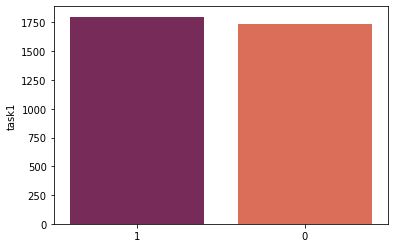

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize training data distribution...
sns.barplot(x=['1', '0'], y=df['task1'].value_counts(), palette="rocket")
plt.show()

In [ ]:
import numpy as np

# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.task1.values
#Convert Labels to binary numeric format
for x in np.arange(len(labels)):
  if labels[x] == "sexist":
    labels[x] = 1
  elif labels[x] == "non-sexist":
    labels[x] = 0
labels = labels.astype("int64")

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BETO can be trained on.

## 3.1. BETO Tokenizer

In [ ]:
from transformers import AutoTokenizer

# Load the BETO tokenizer.
print('Loading BETO tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Nadie te va a tratar tan bien como un hombre que te lo quiere meter por primera vez.
Tokenized:  ['Nadie', 'te', 'va', 'a', 'tratar', 'tan', 'bien', 'como', 'un', 'hombre', 'que', 'te', 'lo', 'quiere', 'meter', 'por', 'primera', 'vez', '.']
Token IDs:  [4228, 1240, 1768, 1013, 4884, 1431, 1311, 1184, 1049, 1900, 1038, 1240, 1114, 2453, 7359, 1096, 2076, 1480, 1009]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.


We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 




**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.




### Sentence Length & Attention Mask




BETO has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BETO vocabulary. 

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't.



## 3.3. Tokenize Dataset

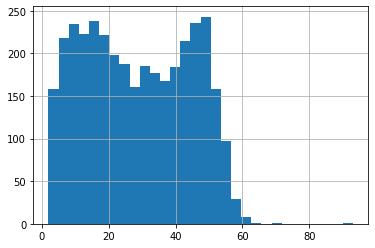

In [ ]:
#Studying sentences length distribution
seq_len = [len(tweet.split()) for tweet in sentences]

pd.Series(seq_len).hist(bins=30)

Just in case there are some longer test sentences, I'll set the maximum length to 100.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Nadie te va a tratar tan bien como un hombre que te lo quiere meter por primera vez.
Token IDs: tensor([   4, 4228, 1240, 1768, 1013, 4884, 1431, 1311, 1184, 1049, 1900, 1038,
        1240, 1114, 2453, 7359, 1096, 2076, 1480, 1009,    5,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,186 training samples
  355 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. AutoModelForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [ ]:
# Exploring number of parameters in model.
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('The model we defined has a total of ', trainable_params, ' trainable parameters.')


The model we defined has a total of  109852418  trainable parameters.
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (31002, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress


Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:51.
  Batch    80  of    100.    Elapsed: 0:01:42.

  Average training loss: 0.63
  Training epcoh took: 0:02:06

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.51
  Validation took: 0:00:05

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:51.
  Batch    80  of    100.    Elapsed: 0:01:41.

  Average training loss: 0.43
  Training epcoh took: 0:02:06

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.49
  Validation took: 0:00:05

Training complete!
Total training took 0:04:23 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.63,0.51,0.78,0:02:06,0:00:05
2,0.43,0.49,0.79,0:02:06,0:00:05


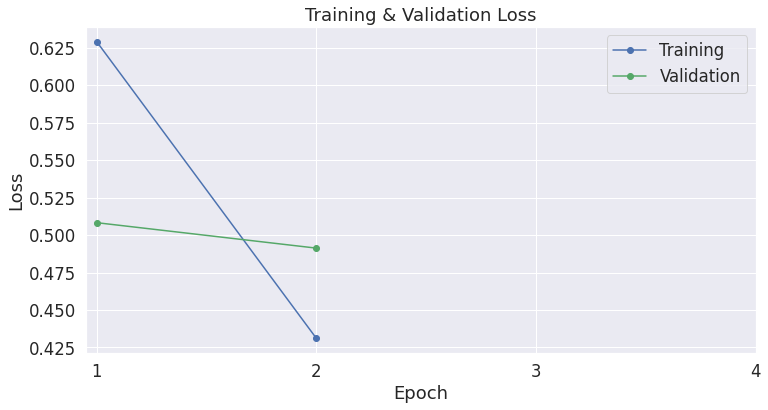

In [ ]:
#Plotting Training and Validation Loss
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./EXIST2021_test_labeled.tsv",delimiter='\t')
df = df[df.language == "es"]
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.task1.values
#Change values to numeric
for x in np.arange(len(labels)):
  if labels[x] == "sexist":
    labels[x] = 1
  elif labels[x] == "non-sexist":
    labels[x] = 0
labels = labels.astype("int64")

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 2,160



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,160 test sentences...
    DONE.


In [ ]:
#Calculate the full list of predictions
pred = []
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred.append(pred_labels_i)

In [ ]:
#Flatten the predictioned labels and true labels
true = np.concatenate(true_labels).ravel().tolist()
pred = np.concatenate(pred).ravel().tolist()

In [ ]:
#Examine a variety of evaluation metrics
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score
print("Accuracy Score: ", np.round(accuracy_score(true, pred),4))
print("Precision Score: ", np.round(precision_score(true, pred),4))
print("Recall Score: ", np.round(recall_score(true, pred),4))
print("F1 Score: ",np.round(f1_score(true, pred),4))

Accuracy Score:  0.7745
Precision Score:  0.8093
Recall Score:  0.7409
F1 Score:  0.7736


#6. Evaluating Model Performance with Captum

"Captum (“comprehension” in Latin) is an open source, extensible library for model interpretability built on PyTorch".
The integrated gradients tool will tell how specific words are contributing towards the classification of the output. Words will be color coded by the degree which they influence the sentence being labeled "sexist" (1) or "non-sexist" (0).

In [ ]:
#Install Captum 
!pip install captum

In [ ]:
#Import dependencies
import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [ ]:
# We need to split forward pass into two part: 
# 1) embeddings computation
# 2) classification

def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_output,
                                         extended_attention_mask,
                                         head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = model_bert.pooler(sequence_output)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
    return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)    


In [ ]:
#Create wrapper class for our model which Captum can interact with.
class BertModelWrapper(nn.Module):
    
    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, embeddings):        
        outputs = compute_bert_outputs(self.model.bert, embeddings)
        pooled_output = outputs[1]
        pooled_output = self.model.dropout(pooled_output)
        logits = self.model.classifier(pooled_output)
        return torch.softmax(logits, dim=1)[:, 1].unsqueeze(1)

In [ ]:
bert_model_wrapper = BertModelWrapper(model)
bert_model_wrapper = bert_model_wrapper.to(device)
ig = IntegratedGradients(bert_model_wrapper)


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

In [ ]:
#Function which will apply integrated gradients to the sentence.
def interpret_sentence(model_wrapper, sentence, label=1):

    model_wrapper.eval()
    model_wrapper.zero_grad()
    
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True)])
    input_ids = input_ids.to(device)
    input_embedding = model_wrapper.model.bert.embeddings(input_ids)
    
    # predict
    pred = model_wrapper(input_embedding).item()
    pred_ind = round(pred)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, n_steps=500, return_convergence_delta=True)

    print('pred: ', pred_ind, '(', '%.2f' % pred, ')', ', delta: ', abs(delta))


    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].to('cpu').numpy().tolist())    
    add_attributions_to_visualizer(attributions_ig, tokens, pred, pred_ind, label, delta, vis_data_records_ig)

In [ ]:
#Function to help add word attributes for visualization
def add_attributions_to_visualizer(attributions, tokens, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().cpu().numpy()
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            pred_ind,
                            label,
                            "label",
                            attributions.sum(),       
                            tokens[:len(attributions)],
                            delta))    

In [ ]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

In [ ]:
#Function call that will predict and assign attributes to a given sentence
#Write in sentence yoou wish to analyze here.
interpret_sentence(bert_model_wrapper, sentence="Cuantos anos tienes tipo? 3 o 4? Vate hijo de puta! a tu proprio hueco de mierda!", label=0)
visualization.visualize_text(vis_data_records_ig)

RuntimeError: ignored